# Modelo Preentrenado para la clasificacion de imagenes

En este cuadernillo se aplicara el modelo entrenado mobilenetv3 para la clasificacion de imagenes

In [1]:
import os
import random
from skimage import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torch.utils.data
import numpy as np
from torchvision import transforms
from tqdm import tqdm
from torch import nn

In [2]:
PATH = r'C:\Users\micky\Downloads\Telegram Desktop\dogs_dataset'
classes = os.listdir(PATH)
classes

['Afgano',
 'Beagle',
 'Bull_Dog_Ingles',
 'Collie',
 'Coocker',
 'German_pointer',
 'Golden_retriever',
 'Pug',
 'Schnauzer']

In [3]:
imgs, labels = [], []

for i, lab in enumerate(classes):
  paths = os.listdir(f'{PATH}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')
  paths = [p for p in paths if p[-3:] == "jpg"]
  imgs += [f'{PATH}/{lab}/{img}' for img in paths]
  labels += [i]*len(paths)

Categoría: Afgano. Imágenes: 5200
Categoría: Beagle. Imágenes: 5200
Categoría: Bull_Dog_Ingles. Imágenes: 5200
Categoría: Collie. Imágenes: 5200
Categoría: Coocker. Imágenes: 5200
Categoría: German_pointer. Imágenes: 5200
Categoría: Golden_retriever. Imágenes: 5200
Categoría: Pug. Imágenes: 5200
Categoría: Schnauzer. Imágenes: 5200


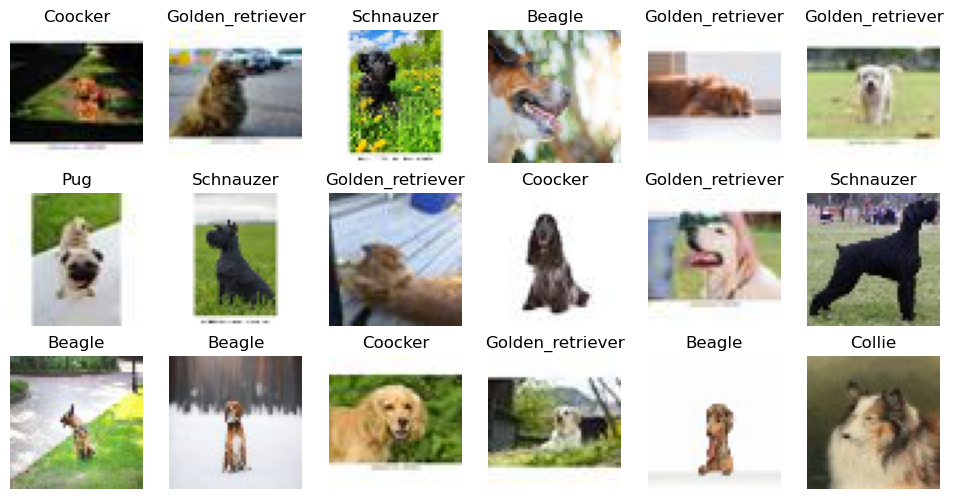

In [4]:
fig, axs = plt.subplots(3,6, figsize=(12,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[labels[ix]])
plt.show()

In [5]:
train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.2, stratify=labels)
len(train_imgs), len(test_imgs)

(33426, 8357)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((50, 50)),
    transforms.Lambda(lambda x: x[:3] if x.shape[0] == 4 else x)
])

class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, device='cpu'):
        self.X = X
        self.y = y
        self.device = device

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ix):
        # Load image from file path
        img = io.imread(self.X[ix])

        # Ensure all images have the same number of channels (RGB)
        if img.ndim == 3:
            if img.shape[2] == 4:  # RGBA
                img = img[:, :, :3]  # Remove alpha channel
        else:
            # Convert grayscale images to RGB
            img = np.stack((img,) * 3, axis=-1)
        
        # Apply the defined transform (converting to tensor and scaling)
        img = transform(img)
        
        # Convert label to tensor
        label = torch.tensor(self.y[ix], dtype=torch.long)
        
        # Move data to the correct device
        img = img.to(self.device)
        label = label.to(self.device)
        
        return img, label


In [7]:
dataset = {
    'train': Dataset(train_imgs, train_labels,device),
    'test': Dataset(test_imgs, test_labels, device)
}

len(dataset['train']), len(dataset['test'])

(33426, 8357)

In [8]:
dataset['train'][2]

(tensor([[[0.9922, 0.9882, 0.9882,  ..., 1.0000, 1.0000, 1.0000],
          [0.9922, 0.9922, 0.9922,  ..., 1.0000, 0.9961, 0.9961],
          [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[0.9961, 0.9922, 0.9922,  ..., 0.9882, 1.0000, 1.0000],
          [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [1.0000, 1.0000, 1.0000,  ..., 0.9882, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.9922, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 0.9843, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.9922, 0.9961, 0.9961],
          [1.0000, 1.0000, 1.0000,  ...,

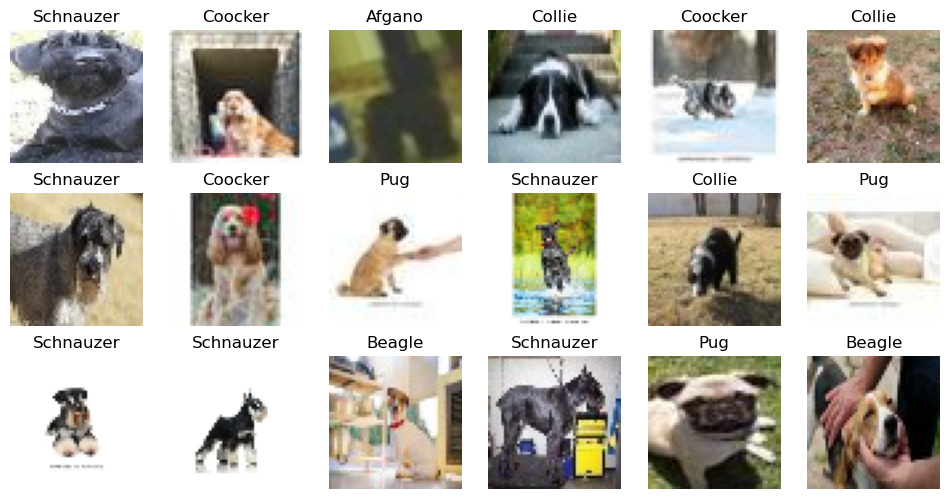

In [9]:
fig, axs = plt.subplots(3,6, figsize=(12,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.cpu().permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

In [10]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 3, 50, 50])

In [11]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models import mobilenet_v3_small

class ModelMobile(torch.nn.Module):
    def __init__(self, n_outputs=12, pretrained=False, freeze=False):
        super().__init__()
        # Load MobileNetV3 model
        mobilenetv3 = torchvision.models.mobilenet_v3_small(pretrained=pretrained)
        # Remove the last layer (fully connected layer)
        self.mobilenetv3 = torch.nn.Sequential(*list(mobilenetv3.children())[:-1])
        # Freeze layers if specified
        if freeze:
            for param in self.mobilenetv3.parameters():
                param.requires_grad = False
        # Add a new fully connected layer for classification
        self.fc = nn.Linear(576, n_outputs)  # MobileNetV3 small outputs 576-dimensional features
        
    def forward(self, x):
        # Forward pass through MobileNetV3
        x = self.mobilenetv3(x)
        # Flatten the features
        x = x.view(x.size(0), -1)
        # Forward pass through the new fully connected layer
        x = self.fc(x)
        return x

    def unfreeze(self):
        # Unfreeze the MobileNetV3 layers
        for param in self.mobilenetv3.parameters():
            param.requires_grad = True


In [12]:
model_mobile = ModelMobile()
outputs_mobile = model_mobile(torch.randn(64, 3, 50, 50))
outputs_mobile.shape

C:\Users\micky\.conda\envs\InteligenciArtificial\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\micky\.conda\envs\InteligenciArtificial\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([64, 12])

In [13]:
def fit(model, dataloader, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [15]:
model_o =ModelMobile (pretrained=True, freeze=True)
fit(model_o, dataloader)
model_o.unfreeze()
fit(model_o, dataloader, lr=1e-4)

C:\Users\micky\.conda\envs\InteligenciArtificial\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to C:\Users\micky/.cache\torch\hub\checkpoints\mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:04<00:00, 2.21MB/s]
val_loss 1.64058 val_acc 0.41563: 100%|██████████| 33/33 [01:02<00:00,  1.90s/it]


Epoch 1/5 loss 1.78963 val_loss 1.64058 acc 0.34658 val_acc 0.41563


val_loss 1.58624 val_acc 0.43578: 100%|██████████| 33/33 [00:56<00:00,  1.73s/it]


Epoch 2/5 loss 1.61102 val_loss 1.58624 acc 0.41637 val_acc 0.43578


val_loss 1.56845 val_acc 0.43425: 100%|██████████| 33/33 [01:11<00:00,  2.18s/it]


Epoch 3/5 loss 1.56756 val_loss 1.56845 acc 0.43505 val_acc 0.43425


val_loss 1.55233 val_acc 0.44779: 100%|██████████| 33/33 [00:51<00:00,  1.58s/it]


Epoch 4/5 loss 1.54454 val_loss 1.55233 acc 0.44161 val_acc 0.44779


val_loss 1.53918 val_acc 0.44955: 100%|██████████| 33/33 [00:54<00:00,  1.65s/it]


Epoch 5/5 loss 1.53074 val_loss 1.53918 acc 0.44690 val_acc 0.44955


val_loss 1.51494 val_acc 0.45780: 100%|██████████| 33/33 [00:54<00:00,  1.66s/it]


Epoch 1/5 loss 1.50881 val_loss 1.51494 acc 0.45641 val_acc 0.45780


val_loss 1.49235 val_acc 0.46389: 100%|██████████| 33/33 [00:53<00:00,  1.62s/it]


Epoch 2/5 loss 1.48632 val_loss 1.49235 acc 0.46488 val_acc 0.46389


val_loss 1.47496 val_acc 0.47241: 100%|██████████| 33/33 [00:53<00:00,  1.62s/it]


Epoch 3/5 loss 1.46616 val_loss 1.47496 acc 0.47166 val_acc 0.47241


val_loss 1.45923 val_acc 0.47797: 100%|██████████| 33/33 [00:50<00:00,  1.53s/it]


Epoch 4/5 loss 1.45208 val_loss 1.45923 acc 0.47853 val_acc 0.47797


val_loss 1.44652 val_acc 0.48443: 100%|██████████| 33/33 [00:57<00:00,  1.74s/it]

Epoch 5/5 loss 1.43688 val_loss 1.44652 acc 0.48422 val_acc 0.48443


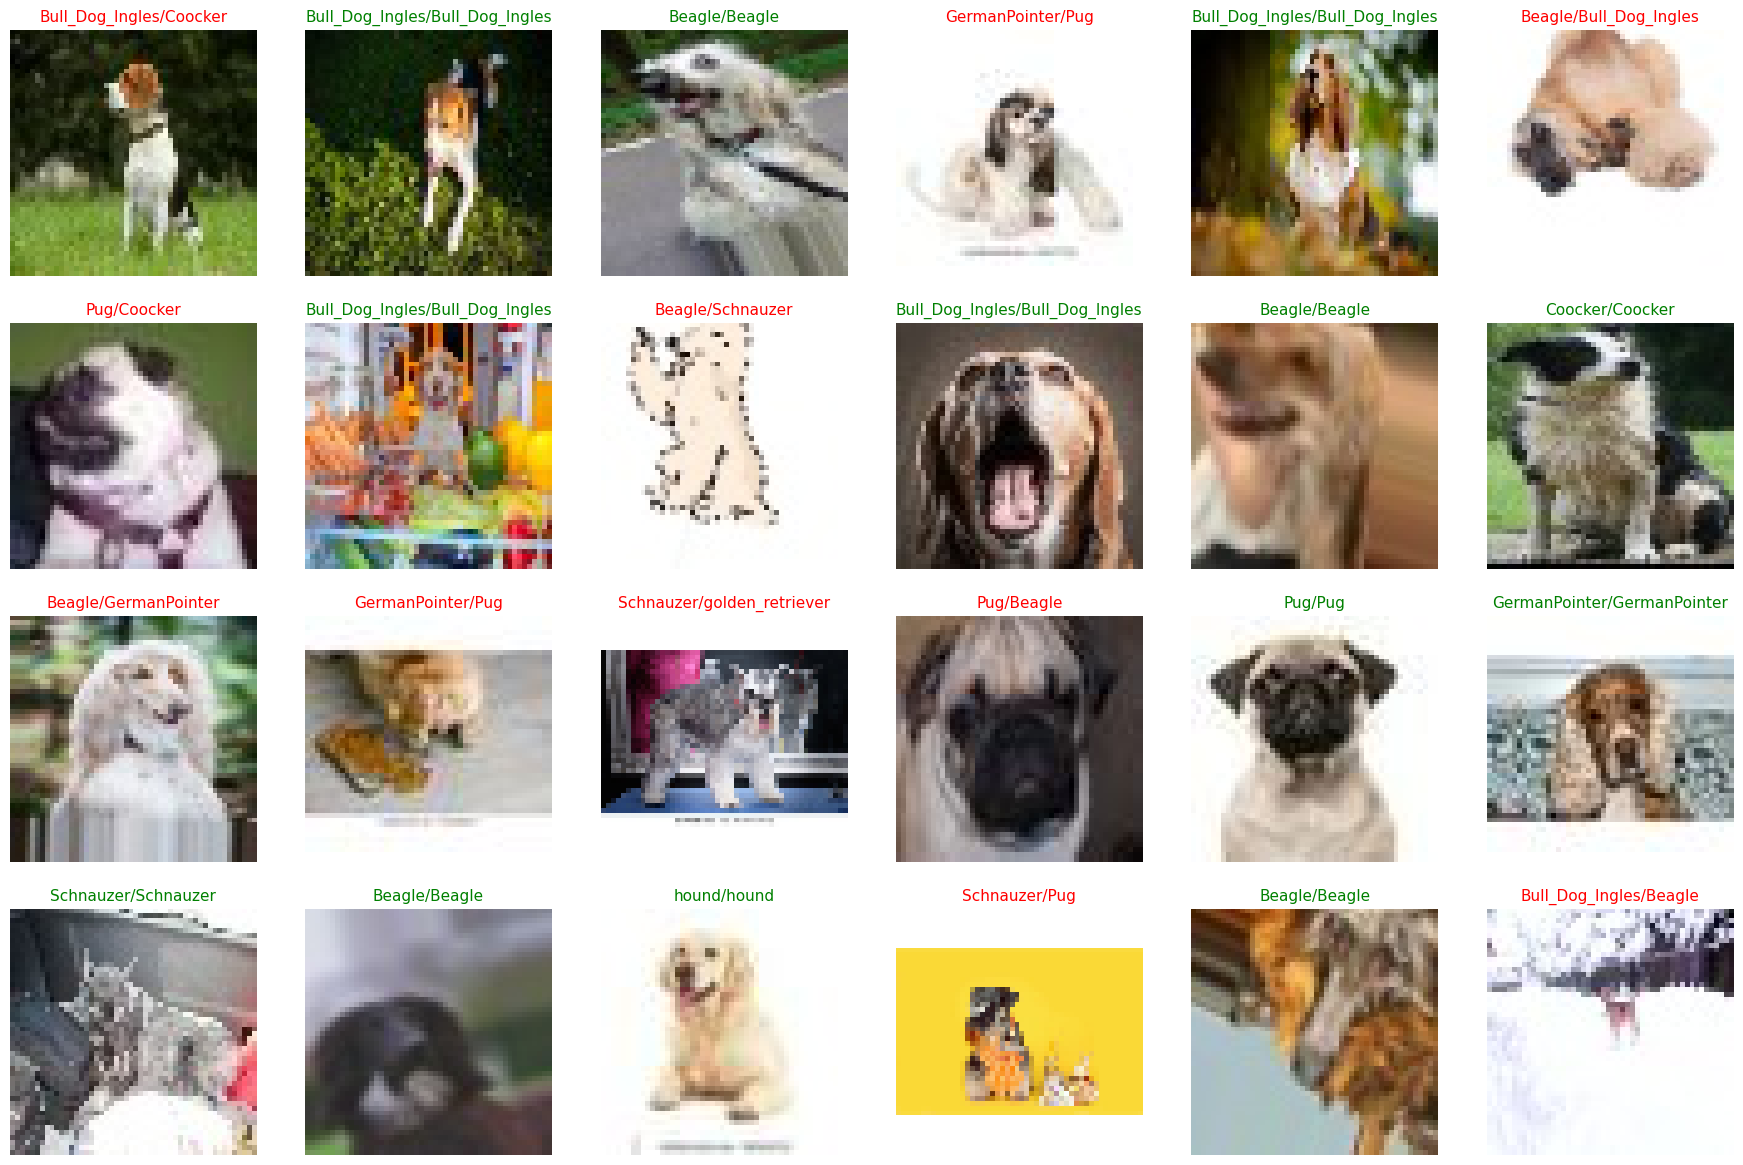

In [18]:
import matplotlib.pyplot as plt

imgs, labels = next(iter(dataloader['test']))
model_o.eval()
with torch.no_grad():
    preds = model_o(imgs.to(device)).argmax(dim=1)

r, c = 4, 6

fig = plt.figure(figsize=(c * 3, r * 3))

class_names = [
    'Beagle',
    'Bull_Dog_Ingles',
    'Collie',
    'Coocker',
    'GermanPointer',
    'golden_retriever',
    'hound',
    'Pug',
    'Schnauzer',
]

# Font size for the title text
font_size = 11

# Loop over the rows and columns of the grid
for _r in range(r):
    for _c in range(c):
        ix = _r * c + _c
        ax = plt.subplot(r, c, ix + 1)

        # Get the image and label for the current grid cell
        img, label = imgs[ix].cpu(), labels[ix].cpu()  # Copiar a la memoria de la CPU
        img = img.permute(1, 2, 0)  # Permute to shape (50, 50, 3)

        # Turn off axis
        ax.axis("off")

        # Display the RGB image directly without reshaping it
        ax.imshow(img)

        # Get the predicted and true class names
        true_class = class_names[label.item()]
        pred_class = class_names[preds[ix].item()]

        # Set the title with the true and predicted class names
        # Color the title green if the prediction is correct, otherwise red
        ax.set_title(
            f'{true_class}/{pred_class}',
            color="green" if label == preds[ix] else 'red',
            fontsize=font_size
        )

# Adjust the layout of the plot
plt.tight_layout(pad=2.0)

# Show the plot
plt.show()
